<a href="https://colab.research.google.com/github/SarthakV7/Financial-analysis/blob/main/Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install statsmodels
!pip install --upgrade plotly

In [5]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [19]:
# lets import some economic data for the US
df = sm.datasets.macrodata.load_pandas().data
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [10]:
# Lets use the 'year' column as a datetime index for our dataframe
index = pd.Index(sm.tsa.datetools.dates_from_range('1959Q1', '2009Q3'))
df.index = index
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


### Let's do some analysis on the GDP data

In [13]:
fig = px.line(df, y='realgdp')
fig.show()

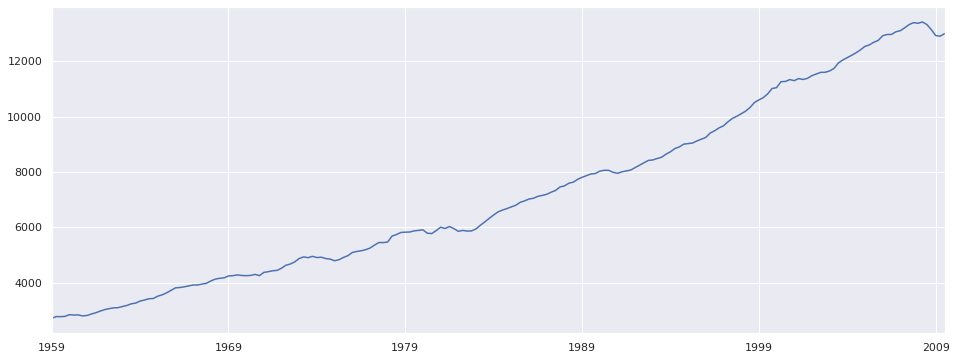

In [14]:
df['realgdp'].plot(figsize=(16,6))
plt.show()

Getting the trand using hpfilter

In [16]:
gdp_cycle, gdp_trend = sm.tsa.filters.hpfilter(df['realgdp']) # returns estimated cycle and trend of the data

In [33]:
df['gdp_trend'] = gdp_trend.values

In [35]:
fig = px.line(df, y=['realgdp', 'gdp_trend'])
fig.show()

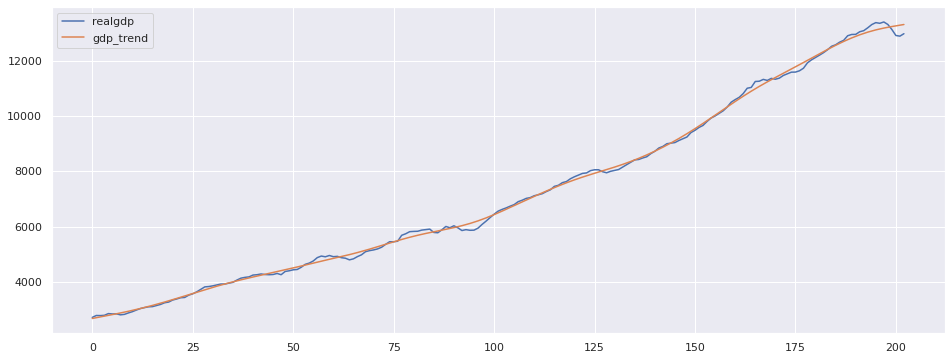

In [37]:
df[['realgdp', 'gdp_trend']].plot(figsize=(16,6))
plt.show()

### EWMA (Exponential Weighted Moving Average)
This is an enhancement of the SMA (Simple Moving Average) which had some weaknesses like:
1.   Smaller window has more noise than signal.
2.   It always lags by the size of the window.
3.   Only describes trends and doesn't tell about the future values.
4.   Extremely skewed values can also skew the SMA significantly.

EWMA is used to fix some of these issues. in EWMA we apply more weights to the recent values and less weights to the older values.

Let's do some analysis on an airline dataset.

In [39]:
df = pd.read_csv('airline_passengers.csv', index_col='Month')
df.dropna(inplace=True)
df.index = pd.to_datetime(df.index) # converting string index to datetime index
df.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


let's create 6 and 12 months moving averages

In [40]:
df['6-month-SMA'] = df['Thousands of Passengers'].rolling(window=6).mean()
df['12-month-SMA'] = df['Thousands of Passengers'].rolling(window=12).mean()

In [43]:
fig = px.line(df, y=df.columns)
fig.show()

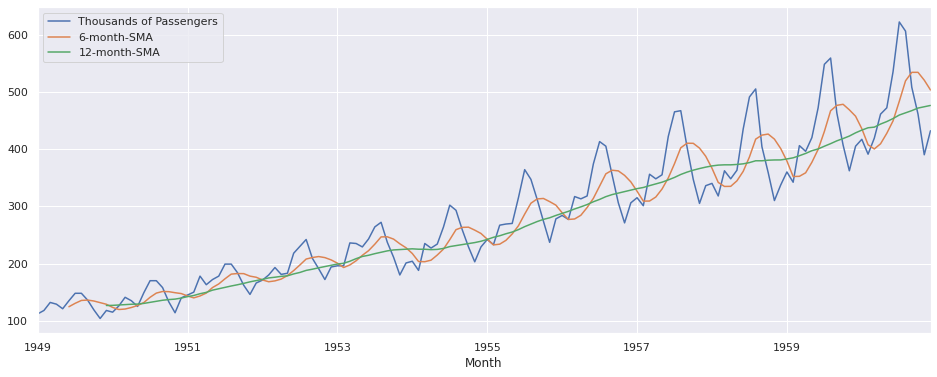

In [44]:
df.plot(figsize=(16,6))
plt.show()

In [47]:
df['EWMA-12'] = df['Thousands of Passengers'].ewm(span=12).mean()

In [48]:
fig = px.line(df, y=['Thousands of Passengers', 'EWMA-12'])
fig.show()

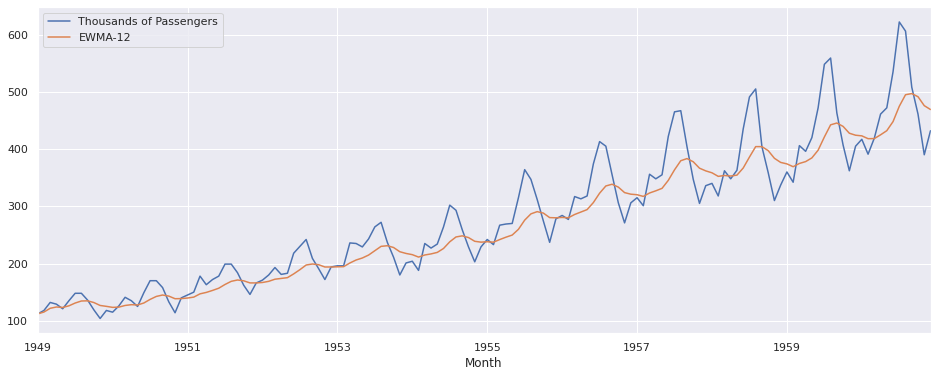

In [49]:
df[['Thousands of Passengers', 'EWMA-12']].plot(figsize=(16,6))
plt.show()

### ETS (Error Trend Seasonality) model

We can breakdown a timeseries data into the error, trend and seasonality terms and then use them later for maybe fitting maybe an ARIMA model to capture relevant info.

In [50]:
df = pd.read_csv('airline_passengers.csv', index_col='Month')
df.dropna(inplace=True)
df.index = pd.to_datetime(df.index) # converting string index to datetime index
df.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Thousands of Passengers'], model='multiplicative')

In [63]:
df['trend'] = result.trend
df['seasonal'] = result.seasonal
df['residual'] = result.resid
fig = px.line(df, y=df.columns)
fig.show()

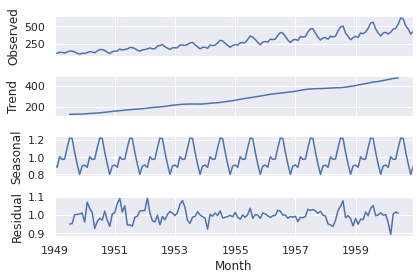

In [65]:
result.plot()
plt.show()

### Stationary vs non-statinoary data:

Some properties of the stationary data are:
*   A stationary series has constant mean and variance over time.
*   A stationary dataset will allow our model to predict that the mean and variance with be the same in the future preiods.
* We can use statistical tests like Dickey-Fuller test to determine if the data is stationary or non-stationary.
* If a dataset is non-stationary we need to convert it to be stationary which can be done through **differencing**.

**Differencing**: In differencing, all we do is taking difference of first order, second order etc. and choose whatever order difference seems stationary. For **seasonal data**, we can also season by a season eg. if we have monthly data with yearly seasonality, we can difference by a time unit of 12 instead of 1 (using pandas shift function).

**One common technique with seasonal ARIMA models is to combine both methods, taking the seasonal difference of the first difference.**

 <img src='https://miro.medium.com/max/1147/1*xdblkZyg6YmmReAkZHUksw.png' width=800px>

### ARIMA models:
These are typically used for capturing the trend (forecasting) of a timeseries data. There are 2 types of ARIMA models, Seasonal ARIMA models and Non-Seasonal ARIMA models (aka ARIMA models). Let's discuss them one by one:

**1.   Seasonal ARIMA models:** Aka ARIMA(p,d,q), where, p,d,q are non negative integers that stand for:
  *   AR(p): [Autoregression]; A regression model that utilizes the dependent relationship between a current observation and observations over the previous period.
  *   I(d): [Integrated]; Differencing of observations (subtracting an observation at the previous time step) in order to make the time series stationary.
  *   MA(q): [Moving Average]; A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

    The values of p, d, q are determined using correlation plots and auto-correlation plots. Let's look into these.

Auto-correlation plots: This represents the relation between the series with itself, lagging by x time units, such that, y-axis is the correlation and x-axis is the number of units of lag.
The plot looks something like:

<img src='https://www.statsmodels.org/stable/plots/graphics_tsa_plot_acf.hires.png' width=500px>

In general, we use either AR or MA, using both is less common. For that, we set the values of p or q. This is decided by:
*   If the auto-correlation shows positive value at the first lag, AR (p) value is used.
*   If the auto-correlation shows negative value at the first lag, MA (q) value is used.
*   Let's understand what these p, d, q are:
    *  p: The number of lag observations included in the model.
    *  d: The number of times that the raw observations are differenced.
    *  q: The size of the moving average window.

There is also [Partial Auto-Correlation Function (PACF)](https://en.wikipedia.org/wiki/Partial_autocorrelation_function#:~:text=In%20time%20series%20analysis%2C%20the,not%20control%20for%20other%20lags.) which is used for identification of an AR model. For identification of MA model, ACF is more relevant.



Let's use ARIMA model on a dataset. The general processes for ARIMA models are the following:
1.   Visualize the time-series data.
2.   Make the time-series data stationary.
3.   Plot the correlation and auto-correlation charts.
4.   Construct and finetune the ARIMA model.
5.   Use the model to make predictions.

In [ ]:
# !pip install --upgrade plotly
import statsmodels.api as sm
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [70]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv', index_col='Month').dropna()
df.index = pd.to_datetime(df.index)
df.columns = ['milk']
df.head()

,milk
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [71]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
milk,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


In [72]:
fig = px.line(df, y='milk')
fig.show()

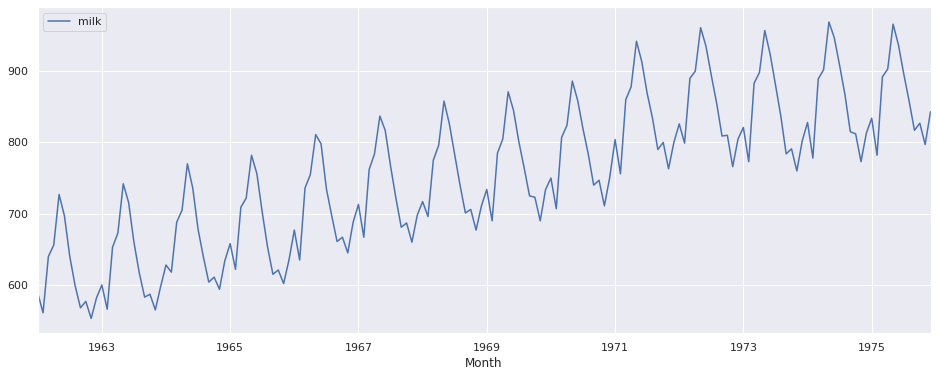

In [74]:
df.plot(figsize=(16,6))
plt.show()

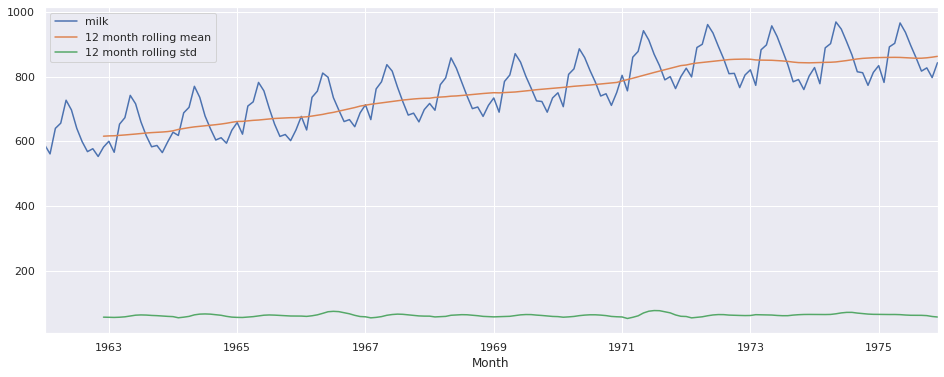

In [79]:
df['milk'].plot(figsize=(16,6))
df['milk'].rolling(12).mean().plot(label='12 month rolling mean')
df['milk'].rolling(12).std().plot(label='12 month rolling std')
plt.legend()
plt.show()

Let's plot the ETS

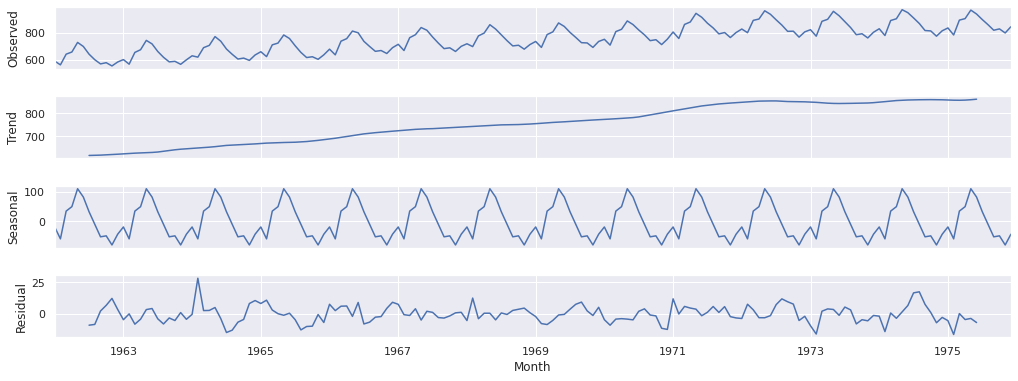

In [84]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['milk'])
fig = result.plot()
fig.set_size_inches(16,6)

Let's perform Dickey-Fuller test on the dataset. DF test assumes: 
*   Null Hypothesis: The data is non-stationary time series.
*   Alternate Hypothesis: The data is stationary time series.

We reject the null hypothesis if p-value is < 0.05 and fail to reject the  null hypothesis if p-value is > 0.05


In [85]:
from statsmodels.tsa.stattools import adfuller

In [101]:
def adf_check(x):
  result = adfuller(x)
  print('-- Augmented Dickey fuller test --')
  labels = ['ADF test statistic:', 'p-value:', 'No. of lags:', 'No. of observations used:']
  for i,j in zip(labels[:2], result[:2]):
    print(i,j)
  if result[1]<=0.05:
    print('Null hypothesis rejected! => Data is stationary! ✅')
  else:
    print('Null hypothesis not rejected! => Data is non-stationary! ❌')

In [102]:
adf_check(df['milk'])

-- Augmented Dickey fuller test --
ADF test statistic: -1.3038115874221285
p-value: 0.6274267086030321
Null hypothesis not rejected! => Data is non-stationary! ❌


Let's calculate difference orders

-- Augmented Dickey fuller test --
ADF test statistic: -3.054995558653089
p-value: 0.030068004001784086
Null hypothesis rejected! => Data is stationary! ✅


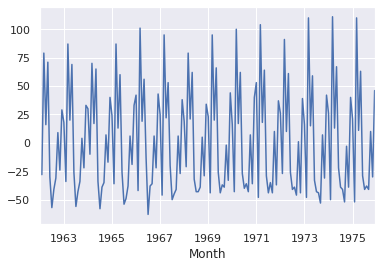

In [106]:
df['first_difference'] = df['milk'] - df['milk'].shift(1)
adf_check(df['first_difference'].dropna())
df['first_difference'].plot()

-- Augmented Dickey fuller test --
ADF test statistic: -2.3354193143594
p-value: 0.16079880527711288
Null hypothesis not rejected! => Data is non-stationary! ❌


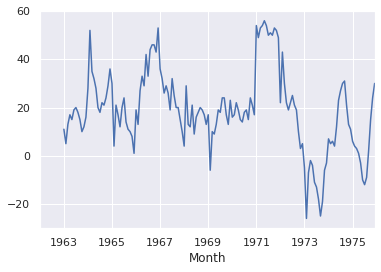

In [107]:
df['seasonal_difference'] = df['milk'] - df['milk'].shift(12)
adf_check(df['seasonal_difference'].dropna())
df['seasonal_difference'].plot()

-- Augmented Dickey fuller test --
ADF test statistic: -5.038002274921983
p-value: 1.865423431878848e-05
Null hypothesis rejected! => Data is stationary! ✅


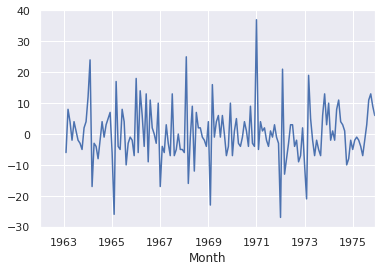

In [108]:
df['seasonal_first_difference'] = df['first_difference'] - df['first_difference'].shift(12)
adf_check(df['seasonal_first_difference'].dropna())
df['seasonal_first_difference'].plot()

Let's plot the Auto-correlation plot and Partial Auto-correlation plot

In [109]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

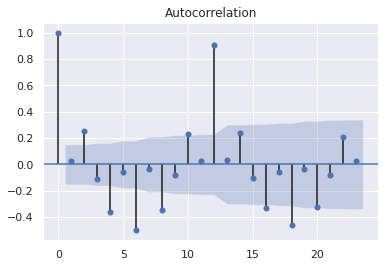

In [110]:
fig_first = plot_acf(df['first_difference'].dropna())

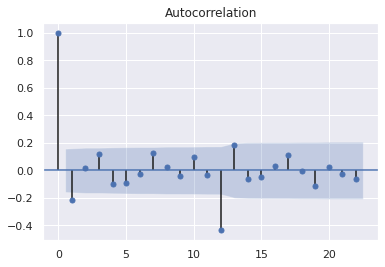

In [111]:
fig_seasonal_first = plot_acf(df['seasonal_first_difference'].dropna())

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



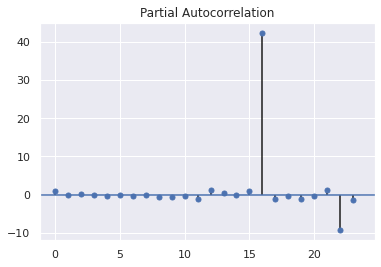

In [112]:
fig_first = plot_pacf(df['first_difference'].dropna())

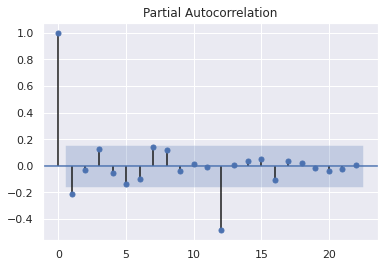

In [113]:
fig_seasonal_first = plot_pacf(df['seasonal_first_difference'].dropna())

Let's implement the ARIMA model

In [121]:
from statsmodels.tsa.arima_model import ARIMA # to import ARIMA model.

In [127]:
# creating train and test dataset using 4:1 split
train = int(df.shape[0]*0.8)
df_train = df['milk'].iloc[:train]
df_test = df['milk'].iloc[train:]

In [128]:
# to import seasonal ARIMA model.
model = sm.tsa.statespace.SARIMAX(df_train, order=(0,1,0),
                                  seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                 Statespace Model Results                                 
Dep. Variable:                               milk   No. Observations:                  134
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -423.457
Date:                            Thu, 29 Apr 2021   AIC                            852.914
Time:                                    21:16:45   BIC                            861.301
Sample:                                01-01-1962   HQIC                           856.320
                                     - 02-01-1973                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0040      0.125      0.032      0.974      -0.242       0.250
ma.S.L12      -0.6427      0.121   

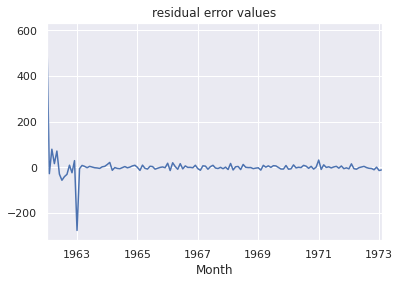

In [129]:
results.resid.plot()
plt.title('residual error values')
plt.show()

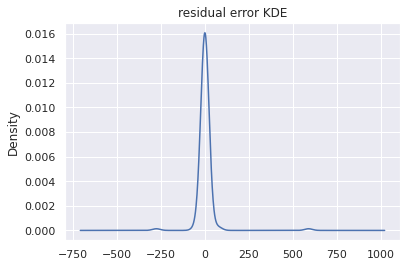

In [130]:
results.resid.plot.kde()
plt.title('residual error KDE')
plt.show()

Let's forecast the test milk data from ARIMA model

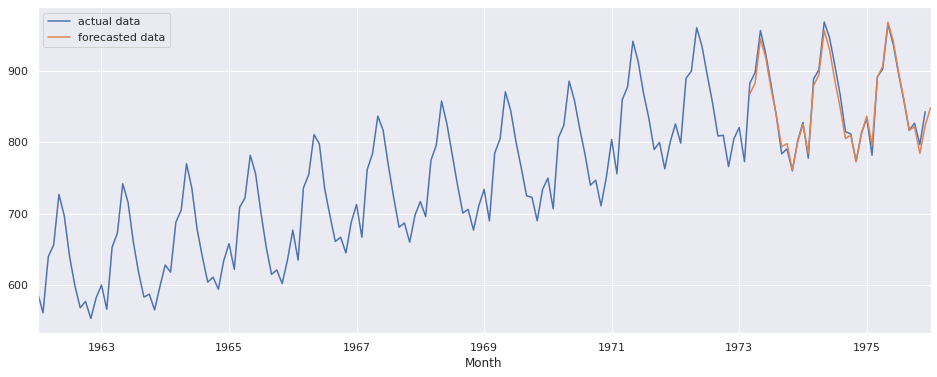

In [139]:
start = train
end = df['milk'].shape[0]
forecasted = results.predict(start, end)
df['milk'].plot(figsize=(16,6), label='actual data')
forecasted.plot(label='forecasted data')
plt.legend()
plt.show()

#### We can see that the ARIMA model works pretty well in predicting the milk in test data. However, this cannot be used in stock market data because ARIMA works well when the y-axis values are a function of x-axis/time. In stock market data, the stock price are not relaed to time and show a idiosyncratic behaviour similar to brownian motion (random), thus, ARIMA fails there. We use concepts like monte carlo simulation that work much better on stock market data.